In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from functools import reduce
from scipy import stats

In [23]:
directory = '../../../Chapters/tables/'

def getSystemPriority():
    clients = pd.read_csv("../data/uat_raw/clientUsers.csv")
    employees = pd.read_csv("../data/uat_raw/employeUsers.csv")

    # Merge the two dataframes based on matching SubSystemId values
    merged_df = pd.merge(clients, employees, on='SubSystemId', how='outer', suffixes=('_df1', '_df2'))

    # Replace any NaN values with 0
    merged_df.fillna(0, inplace=True)

    # Calculate TotalUserCount where UserCount values are equal
    merged_df['TotalUserCount'] = merged_df.apply(lambda row: row['UserCount_df1'] + row['UserCount_df2'], axis=1)

    return merged_df

def getBaseProjectData(file):
    """
    Gets the base data for the project

    Returns:
    A dataframe with user activities
    """
    systemsData = pd.read_csv("../data/uat_raw/systems.csv")
    projectBaseData = pd.read_csv(f"../data/uat_raw/{file}.csv")
    priority = getSystemPriority()
    users = pd.read_csv("../data/uat_raw/users.csv")

    temp = pd.merge(systemsData, projectBaseData,on='SubSystemId')
    temp = pd.merge(users, temp, on='UserId')
    temp = pd.merge(priority, temp, on='SubSystemId')

    return temp.loc[(temp['Project'] == 1) & (temp['Deleted'] == 1)], temp.loc[(temp['Project'] == 2) & (temp['Deleted'] == 1)];

def getNormalisedByTotal(data):
    temp = data.groupby(['SubSystemId']).agg(
        TotalUserCount=('TotalUserCount', 'mean'),
        Count=('SubSystemId', 'count')
    ).reset_index()

    # Normalize TotalUserCount
    min_total_user_count = temp['TotalUserCount'].min()
    max_total_user_count = temp['TotalUserCount'].max()
    temp['Priority'] = (temp['TotalUserCount'] - min_total_user_count) / (max_total_user_count - min_total_user_count)

    # Normalize Count
    min_count = temp['Count'].min()
    max_count = temp['Count'].max()
    temp['NormalisedCount'] = (temp['Count'] - min_count) / (max_count - min_count)

    # Calculate MaintenanceFactor
    temp['MaintenanceFactor'] = temp['NormalisedCount'] * temp['Priority']

    return temp

def getNormilisedBySecondCriteria(data, secondFilter):
    temp = data.groupby(['SubSystemId',secondFilter]).agg(TotalUserCount=('TotalUserCount', 'mean'),
     Count=('SubSystemId', 'count')).reset_index()

    min_count = temp['TotalUserCount'].min()
    max_count = temp['TotalUserCount'].max()

    temp['Priority'] = temp['TotalUserCount'].apply(lambda x: 
        (x-min_count)/(max_count-min_count))

    # get the number of unique entries in the 'ActivityType' column
    num_activity_types = data[secondFilter].nunique()

    # get the first 'Priority' value for each 'SubSystemId'
    first_priority = temp.groupby('SubSystemId')['Priority'].first()

    # pivot the table and merge with the first priority values
    pivoted_df = temp.pivot_table(index='SubSystemId', columns=secondFilter, values='Count', fill_value=0)
    pivoted_df = pivoted_df.merge(first_priority, left_index=True, right_index=True).reset_index()

    # get all unique entries in the 'x' column
    unique_values = data[secondFilter].unique()

    for name in unique_values:
        normalised_table_name = f'NormalisedCount_{name}'
        maintenance_table_name = f'MaintenanceFactor_{name}'
        pivoted_min = pivoted_df[name].min()
        pivoted_max = pivoted_df[name].max()

        # calculate the normalized count
        pivoted_df[normalised_table_name] = (pivoted_df[name] - pivoted_min) / (pivoted_max - pivoted_min)

        # calculate the maintenance factor
        pivoted_df[maintenance_table_name] = pivoted_df[normalised_table_name] * pivoted_df['Priority']

    return pivoted_df

In [24]:
# Get project actvities
projectB, projectA = getBaseProjectData('uat1')

# Get project total activities per project
projectA_Normilised = getNormalisedByTotal(projectA)
projectB_Normilised = getNormalisedByTotal(projectB)
projectA_expanded = getNormilisedBySecondCriteria(projectA, 'ActivityType')

# Test data
testA, testB = getBaseProjectData('test_data')

# Get project total activities per project
testB_Normilised = getNormalisedByTotal(testB)

In [25]:
def createLatexRows(data, filename, caption, testData):
    data = data.sort_values(by='MaintenanceFactor', ascending=False)

    # select the top 25 entries
    #data = data.head(40)

    #data = data.sort_values(by='SubSystemId', ascending=True)
    data['rank'] = data['MaintenanceFactor'].rank(method='min', ascending=False)

    latex_rows = ''
    for index, row in data.iterrows():
        systemId = f"$S_{index+1}$" if testData else f"$S_{{{int(row['SubSystemId'])}}}$"
        latex_rows += '\n {:s} & {:d} & {:.4f} & {:d} & {:.4f} & {:.4f} & {:d} \\\ \\hline'.format(systemId, int(row['TotalUserCount']) ,row['Priority'], int(row['Count']), row['NormalisedCount'], row['MaintenanceFactor'], int(row['rank']))

    system = '$S_{X}$'

    header = r"""
    \begin{xltabular}{\textwidth}{|X|X|X|X|X|X|X|}
        \caption[%s]
        {\textit{%s}}
        \label{tbl:apx_%s} \\
        
        \hline
        \textbf{%s} & \textbf{$P_X$} & \textbf{$P_N$}  & \textbf{$A_X$} & \textbf{$A_N$} & \textbf{$M_{PF}$} & \textbf{$P_{R}$} \\
        \hline
        \endfirsthead

        \multicolumn{7}{c}
        {\tablename\ \thetable{} -- continued from previous page} \\
        \hline
        \textbf{%s} & \textbf{$P_X$} & \textbf{$P_N$}  & \textbf{$A_X$} & \textbf{$A_N$} & \textbf{$M_{PF}$} & \textbf{$P_{R}$} \\ 
        \endhead

        \multicolumn{7}{|r|}{{Continued on next page}} \\ \hline
        \endfoot

        \hline
        \endlastfoot
    """ % (caption, caption, filename, system, system) 
    
    table = header + latex_rows.strip() + r"""
    \end{xltabular}
    """

    filepath = directory + filename + '.tex'

    # Write the latex_rows string to the file
    with open(filepath, 'w') as f:
        f.write(table)


createLatexRows(projectA_Normilised, "projectA_Normilised", "Case study A results", False)
createLatexRows(projectB_Normilised, "projectB_Normilised", "Case study B results", False)

# Test data 
createLatexRows(testB_Normilised, "testB_Normilised", "Test data", True)

In [26]:
def createFigures(data, case):
    # sort the dataframe by the 'score' column in descending order
    data = data.sort_values(by='Count', ascending=False)

    # select the top 25 entries
    data = data.head(40)

    # sort the dataframe by the 'score' column in descending order
    data = data.sort_values(by='SubSystemId')

    sns.set(style="darkgrid")
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["figure.figsize"] = (16,9)

    # get the unique SubSystemIds
    subsystem_ids = data['SubSystemId'].unique()

    # set the number of subsystems to show per graph
    num_subsystems_per_graph = 300

    # calculate the number of graphs needed
    num_graphs = int(np.ceil(len(subsystem_ids) / num_subsystems_per_graph))

    data['SS_SystemId'] = '$S_{' + data['SubSystemId'].astype(str) + '}$'

    # loop through each graph
    for i in range(num_graphs):
        start_index = i * num_subsystems_per_graph
        end_index = min((i+1) * num_subsystems_per_graph, len(subsystem_ids))
        current_ids = subsystem_ids[start_index:end_index]

        # filter the data to show only the current subsystem ids
        current_data = data[data['SubSystemId'].isin(current_ids)]

        # create figure and axis objects with subplots()
        fig, ax = plt.subplots()

        # create a twin axis object that shares the x-axis
        ax2 = ax.twinx()

        # plot the bar chart
        current_data.plot(kind='bar', x='SS_SystemId', y='Count', ax=ax, color='mediumturquoise', legend=False)
        ax.set_ylabel('User activities')

        # plot the line graph on the twin axis
        current_data.plot(kind='line', x='SS_SystemId', y='MaintenanceFactor', ax=ax2, color='red', legend=False)
        ax2.set_ylabel(r'Maintenance Factor $M_{PF}$')

        # set the x-axis label and tick label rotation
        ax.set_xlabel(r'Subsystem $S_X$')
        plt.xticks(rotation='45', ha='right')

        # add a title to the chart
        plt.title(f'Subsystem vs. User activities and Maintenance Factor')

        # save the current figure
        plt.savefig(f'../../../img/ch3/analysis/case_{case}_subsystems_{i+1}.pdf', format="pdf", bbox_inches="tight")

        # close the figure to free memory
        plt.close(fig)

createFigures(projectA_Normilised, 'A')
createFigures(projectB_Normilised, 'B')

In [27]:
df = pd.read_csv("../data/uat_raw/systems2.csv")

# Remove rows with null values in 'System' column
df = df.dropna(subset=['System'])

# Add unique SystemId to the dataframe
df['SystemId'] = pd.factorize(df['System'])[0] + 1

# create a dictionary to map subsystem path to subsystem id
subsystem_id_map = {subsys: idx+1 for idx, subsys in enumerate(df['SubSystem'].unique())}

# update subsystem ids that have the same first two parts
for idx, subsys in enumerate(df['SubSystem'].unique()):
    parts = subsys.strip('/').split('/')
    subsys_key = '/'.join(parts[:2])
    if subsys_key in subsystem_id_map and subsystem_id_map[subsys_key] != idx+1:
        subsystem_id_map[subsys] = subsystem_id_map[subsys_key]

# map subsystem path to subsystem id in the dataframe
df['SubsystemUId'] = df['SubSystem'].apply(lambda x: subsystem_id_map[x])

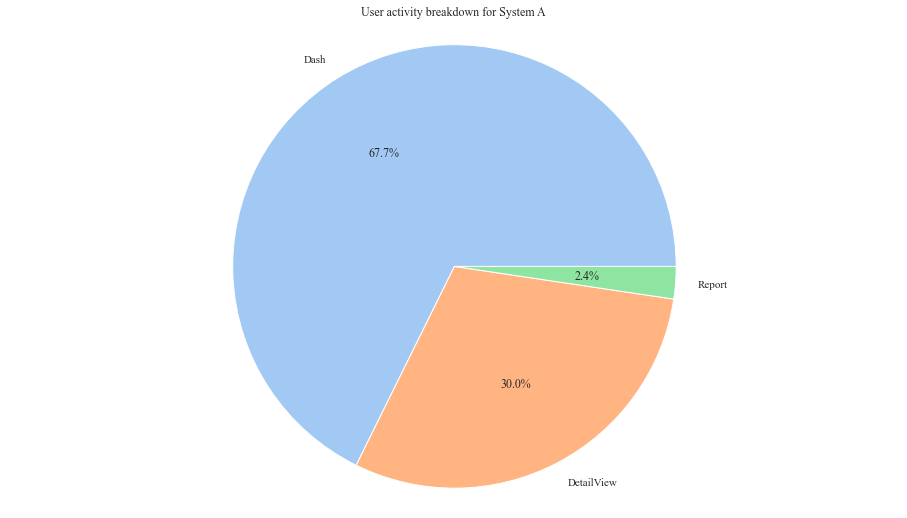

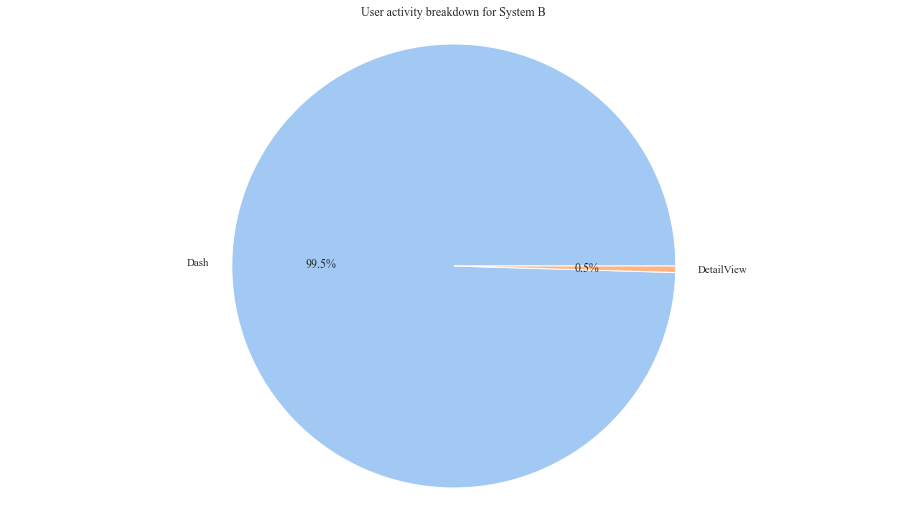

In [28]:
def uatBreakdown(data, label):
    # Count the occurrences of each category
    category_counts = data['ActivityType'].value_counts()

    # Define Seaborn color palette to use
    colors = sns.color_palette('pastel')[0:10]

    # Create a new figure
    plt.figure()

    # Plotting a pie chart
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["figure.figsize"] = (16, 9)
    plt.pie(category_counts, labels=category_counts.index, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')  # Ensure that pie is drawn as a circle
    plt.title('User activity breakdown for System ' + label)

    # Save the current figure
    plt.savefig(f'../../../img/ch3/analysis/case_{label}_breakdown.pdf', format="pdf", bbox_inches="tight")

uatBreakdown(projectA, 'A')
uatBreakdown(projectB, 'B')